# Variational Autoencoder

Required imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Input, Lambda, Reshape,Dropout,BatchNormalization, Flatten
from keras.datasets import mnist
from keras import backend as K
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


Get the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

11493376/11490434 [==============================] - 1s 0us/step


Model architecture

In [3]:
batch_size=200
inputs = Input(batch_shape=(batch_size, 28, 28, 1))


#dims = np.array([128, 32, 2])
def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, 2), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon


def encode(x):
    x=Flatten()(x)
    x=Dense(256, activation='relu')(x)
    x=Dropout(0.25)(BatchNormalization()(x))
    x=Dense(128, activation='relu')(x)
    x=Dropout(0.25)(BatchNormalization()(x))
    z_mean=Dense(2)(x)
    z_log_var=Dense(2)(x)
    
    l = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
    encoding=Model(inputs,l)
    return encoding, z_mean, z_log_var
encoding, z_mean,z_log_var=encode(inputs)

z = Input(shape=(2, ))
def decode(z):
    x=Dense(128)(z)
    x=LeakyReLU()(x)
    x=Dropout(0.25)(BatchNormalization()(x))
    x=Dense(256)(x)
    x=LeakyReLU()(x)
    x=Dropout(0.25)(BatchNormalization()(x))
    x=Dense(28*28, activation='sigmoid')(x)
    decoded=Reshape((28,28,1))(x)
    return Model(z,decoded)
decoding=decode(z)


autoencoder = Model(inputs, decoding(encoding(inputs)))
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (200, 28, 28, 1)          0         
_________________________________________________________________
model_1 (Model)              (200, 2)                  235908    
_________________________________________________________________
model_2 (Model)              multiple                  236432    
Total params: 472,340
Trainable params: 470,804
Non-trainable params: 1,536
_________________________________________________________________


Set optimizer and loss

In [0]:
def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, 28*28))
        decoded = K.reshape(decoded, shape=(batch_size, 28*28))
        xent_loss = 28*28*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/28/28

In [0]:
autoencoder.compile(optimizer='adam', loss=vae_loss)

Train the model

In [7]:
history = autoencoder.fit(x_train, x_train, shuffle=True,epochs=100, batch_size=batch_size)

Epoch 1/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1826
Epoch 2/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1128
Epoch 3/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1096
Epoch 4/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1082
Epoch 5/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1073
Epoch 6/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1067
Epoch 7/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1063
Epoch 8/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1059
Epoch 9/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1057
Epoch 10/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1056
Epoch 11/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1053
Epoch 12/100
60000/60000 [===============

Let's get hidden representation for all imaages in dataset

In [0]:

hidden = encoding.predict(x_train,batch_size=batch_size)

Hidden space visualization

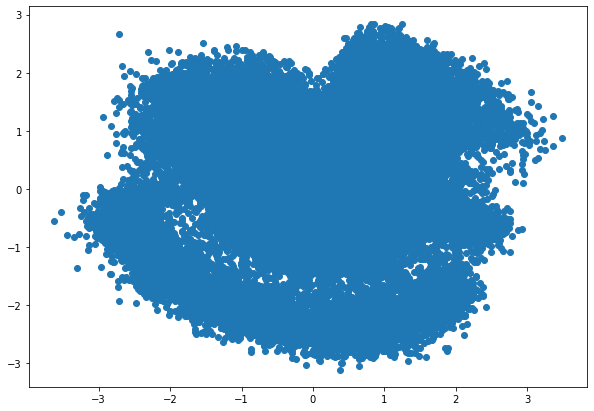

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(*hidden.T)
plt.show()

Let's explore hidden space for sample digits:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

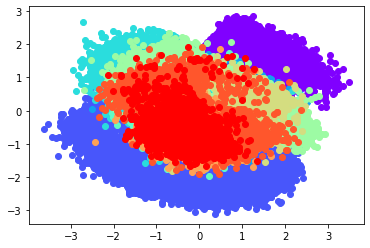

In [10]:
import matplotlib.cm as cm
x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
for i,c in zip(range(10),colors):
    plt.scatter(*hidden[y_train == i].T, c=c)
plt.show()

Generation of new images from hidden space:

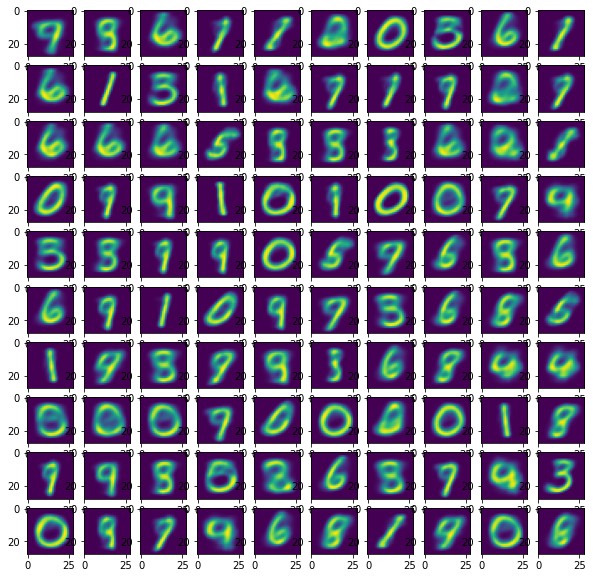

In [11]:
means = encoding.predict(x_train, batch_size=batch_size).mean(axis=0)
stds = encoding.predict(x_train,batch_size=batch_size).std(axis=0)
z = np.random.normal(loc=means, scale=stds, size=(100, 2))
res = decoding.predict(z)

plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(res[i * 10 + j, :, :, 0])

Done!